# <font color = 'pickle'>**Extractive Question Answering Given Context with SQuad** </font>


## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Exploring and Understanding IMDB Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.



# <font color = 'pickle'> **Setting up the Environment** </font>

In [2]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


In [3]:
# import textwrap
import textwrap
def print_wrap(text, d, highlight = False,highlight_word = None):
    # If the text is a list, convert it to a string
    if isinstance(text, list):
        # Convert None values to a default string (e.g., "None" or an empty string)
        text = ' '.join(str(item) if item is not None else "None" for item in text)

    if highlight:
        # Highlight the word
        text = text.replace(highlight_word, f'\033[91m{highlight_word}\033[0m')
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

    
def print_wrap_dict(data, d):
    for key, value in data.items():
        # Wrap and print the key
        wrapped_key = textwrap.fill(key + ':', width=d)
        print(wrapped_key, end=' ')

        # Convert the list values to a string and wrap it
        value_string = ', '.join(map(str, value))
        wrapped_value = textwrap.fill(value_string, width=d, subsequent_indent=' ' * (len(key) + 2))

        # Print the wrapped value
        print(wrapped_value)

# <font color = 'pickle'> **Exploring and Understanding Dataset**

## <font color = 'pickle'> **Load Data set**
    


In [4]:
from datasets import load_dataset

In [5]:
squad_dataset = load_dataset("squad")

## <font color = 'pickle'> **Understanding your data**

In [6]:
print(squad_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


## <font color = 'pickle'> **Understanding the datatype of columns**


In [7]:
squad_dataset['train'].features

{'id': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}

## <font color = 'pickle'> **Acess indivdual element** </font>
 The dataset behaves like an Python array or list. We can use the familiar indexing/slicing methods to access individual elements.

In [8]:
# get the first example of the dataset
squad_dataset['train'][0]


{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [9]:
print("Context:")
print_wrap(squad_dataset["train"][0]["context"], 80)
print("\nQuestion:")
print_wrap(squad_dataset["train"][0]["question"], 80)
print("\nAnswer:")
print(squad_dataset["train"][0]["answers"])


Context:
Architecturally, the school has a Catholic character. Atop the Main Building's
gold dome is a golden statue of the Virgin Mary. Immediately in front of the
Main Building and facing it, is a copper statue of Christ with arms upraised
with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica
of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian
place of prayer and reflection. It is a replica of the grotto at Lourdes, France
where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.
At the end of the main drive (and in a direct line that connects through 3
statues and the Gold Dome), is a simple, modern stone statue of Mary.

Question:
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

Answer:
{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}


## <font color = 'pickle'> **Exploratory Data Analysis (EDA)**

### <font color = 'pickle'> **Change dataset format to Pandas**  </font>
We will convert the datasets to Pandas DataFrames for visualization and Exploratory Data Analysis (EDA) because Pandas provides a wide range of tools and functions that simplify data manipulation, aggregation, and visualization, making it an ideal choice for these tasks

In [10]:
# this will convert all the splits into Pandas dataframe
squad_dataset.set_format(type='pandas')

In [11]:
# get all rows from tarining split
df_train = squad_dataset['train'][:]
df_valid = squad_dataset['validation'][:]

In [12]:
df_train.head()


,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        87599 non-null  object
 1   title     87599 non-null  object
 2   context   87599 non-null  object
 3   question  87599 non-null  object
 4   answers   87599 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


### <font color = 'pickle'> **Check Number of answers** </font>
Let us check how many answers we have per question

In [14]:
# check distribution of class labels in training dataset
df_train['number_answers'] = df_train['answers'].apply(lambda x: len(x['text']))


In [15]:
df_train['number_answers'].value_counts()

number_answers
1    87599
Name: count, dtype: int64

In [16]:
df_valid['number_answers'] = df_valid['answers'].apply(lambda x: len(x['text']))

In [17]:
df_valid['number_answers'].value_counts()

number_answers
3    8490
5    1147
4     759
2     136
6      35
1       3
Name: count, dtype: int64

In [18]:
df_valid['answers'][0]

{'text': array(['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], dtype=object),
 'answer_start': array([177, 177, 177], dtype=int32)}

In [19]:
print_wrap(df_valid['context'][2], 90)

Super Bowl 50 was an American football game to determine the champion of the National
Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion
Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers
24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at
Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the
50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed
initiatives, as well as temporarily suspending the tradition of naming each Super Bowl
game with Roman numerals (under which the game would have been known as "Super Bowl L"),
so that the logo could prominently feature the Arabic numerals 50.


In [20]:
print_wrap(df_valid['question'][2], 90)

Where did Super Bowl 50 take place?


In [21]:
print(df_valid['answers'][2])

{'text': array(['Santa Clara, California', "Levi's Stadium",
       "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."],
      dtype=object), 'answer_start': array([403, 355, 355], dtype=int32)}


### <font color = 'pickle'> **Check length of the Context** </font>


In [22]:
df_train['words_per_context'] = df_train['context'].str.split().apply(len)
df_valid['words_per_context'] = df_valid['context'].str.split().apply(len)


#### <font color = 'pickle'> **Plot the distribution of review length** </font>

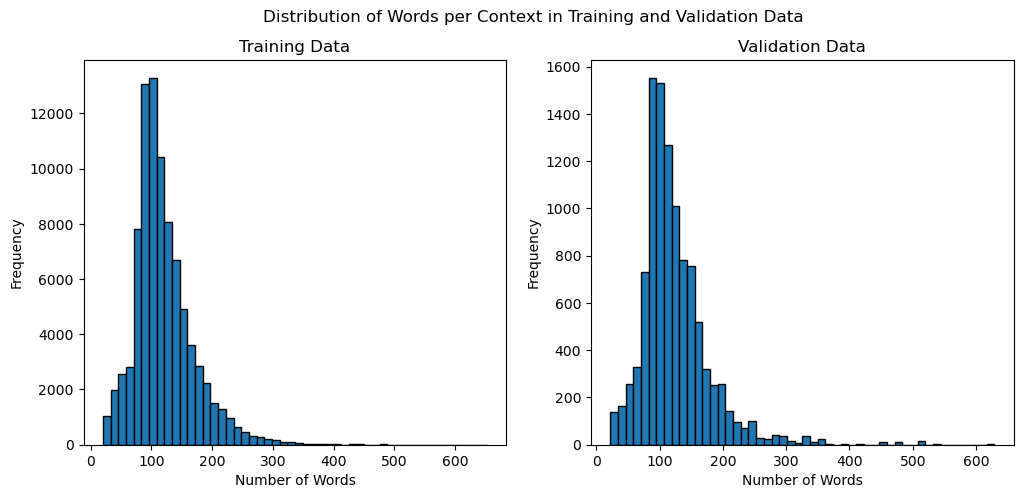

In [23]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# Plot a histogram for the training data in the first subplot
axes[0].hist(df_train['words_per_context'], bins=50, edgecolor='black')
axes[0].set_title('Training Data')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')

# Plot a histogram for the validation data in the second subplot
axes[1].hist(df_valid['words_per_context'], bins=50, edgecolor='black')
axes[1].set_title('Validation Data')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')

# Add a main title for the entire figure
plt.suptitle('Distribution of Words per Context in Training and Validation Data')

# Display the plot
plt.show()



In [24]:
# The model we are going to use has token (subwords) limit of 512.
# Let us check how many reviews has more than 400 words

count_train = (df_train['words_per_context'] > 400).sum()
count_valid = (df_valid['words_per_context'] > 400).sum()
print(f"Number of contexts with more than 400 words: {count_train}, {count_valid}")


Number of contexts with more than 400 words: 75, 49


### <font color = 'pickle'> **Reset dataset format** </font>


In [25]:
squad_dataset.reset_format()

In [26]:
squad_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

# <font color = 'pickle'> **Data Pre-processing**</font>

### <font color = 'pickle'> **Extract Splits**

In [28]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)


In [29]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1000
    })
})

In [36]:
print_wrap_dict(squad["train"][0:1], 100)

id: 56be96653aeaaa14008c9117
title: Beyoncé
context: Beyoncé further expanded her acting career, starring as blues singer Etta James in the 2008 musical
         biopic, Cadillac Records. Her performance in the film received praise from critics, and she
         garnered several nominations for her portrayal of James, including a Satellite Award
         nomination for Best Supporting Actress, and a NAACP Image Award nomination for Outstanding
         Supporting Actress. Beyoncé donated her entire salary from the film to Phoenix House, an
         organization of rehabilitation centers for heroin addicts around the country. On January
         20, 2009, Beyoncé performed James' "At Last" at the First Couple's first inaugural ball.
         Beyoncé starred opposite Ali Larter and Idris Elba in the thriller, Obsessed. She played
         Sharon Charles, a mother and wife who learns of a woman's obsessive behavior over her
         husband. Although the film received negative reviews fro

## <font color = 'pickle'> **Tokenization**</font>

###  <font color = 'pickle'> **Load pre-trained Tokenizer** </font>

In [46]:
from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


###  <font color = 'pickle'> **Understanding Tokenization Questions-Context pair**
We will now understand how the tokenizer work by feeding one simple example.

####  <font color = 'pickle'> **One example**

In [47]:
context = squad["train"][0]["context"]
question = squad["train"][0]["question"]
answer = squad["train"][0]["answers"]

In [48]:
print_wrap(context, 100)
print()
print_wrap(question, 100)
print()
print_wrap_dict(answer, 100)

Beyoncé further expanded her acting career, starring as blues singer Etta James in the 2008 musical
biopic, Cadillac Records. Her performance in the film received praise from critics, and she garnered
several nominations for her portrayal of James, including a Satellite Award nomination for Best
Supporting Actress, and a NAACP Image Award nomination for Outstanding Supporting Actress. Beyoncé
donated her entire salary from the film to Phoenix House, an organization of rehabilitation centers
for heroin addicts around the country. On January 20, 2009, Beyoncé performed James' "At Last" at
the First Couple's first inaugural ball. Beyoncé starred opposite Ali Larter and Idris Elba in the
thriller, Obsessed. She played Sharon Charles, a mother and wife who learns of a woman's obsessive
behavior over her husband. Although the film received negative reviews from critics, the movie did
well at the US box office, grossing $68 million—$60 million more than Cadillac Records—on a budget
of $20 mil

In [49]:
encoded_text = tokenizer(context, question)

In [50]:
print_wrap_dict(encoded_text, 120)

input_ids: 101, 20773, 2582, 4423, 2014, 3772, 2476, 1010, 4626, 2004, 5132, 3220, 3802, 2696, 2508, 1999, 1996, 2263, 3315, 16012,
           24330, 1010, 20425, 2636, 1012, 2014, 2836, 1999, 1996, 2143, 2363, 8489, 2013, 4401, 1010, 1998, 2016,
           13056, 2195, 9930, 2005, 2014, 13954, 1997, 2508, 1010, 2164, 1037, 5871, 2400, 6488, 2005, 2190, 4637, 3883,
           1010, 1998, 1037, 26155, 3746, 2400, 6488, 2005, 5151, 4637, 3883, 1012, 20773, 6955, 2014, 2972, 10300,
           2013, 1996, 2143, 2000, 6708, 2160, 1010, 2019, 3029, 1997, 11252, 6401, 2005, 19690, 26855, 2015, 2105,
           1996, 2406, 1012, 2006, 2254, 2322, 1010, 2268, 1010, 20773, 2864, 2508, 1005, 1000, 2012, 2197, 1000, 2012,
           1996, 2034, 3232, 1005, 1055, 2034, 7725, 3608, 1012, 20773, 5652, 4500, 4862, 2474, 19418, 1998, 8909, 6935,
           3449, 3676, 1999, 1996, 10874, 1010, 15896, 1012, 2016, 2209, 10666, 2798, 1010, 1037, 2388, 1998, 2564,
           2040, 10229, 1997, 1037, 2450, 1

In [51]:
tokens = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids)

print_wrap(tokens, 100)

[CLS] beyonce further expanded her acting career , starring as blues singer et ##ta james in the
2008 musical bio ##pic , cadillac records . her performance in the film received praise from critics
, and she garnered several nominations for her portrayal of james , including a satellite award
nomination for best supporting actress , and a naacp image award nomination for outstanding
supporting actress . beyonce donated her entire salary from the film to phoenix house , an
organization of rehabilitation centers for heroin addict ##s around the country . on january 20 ,
2009 , beyonce performed james ' " at last " at the first couple ' s first inaugural ball . beyonce
starred opposite ali la ##rter and id ##ris el ##ba in the thriller , obsessed . she played sharon
charles , a mother and wife who learns of a woman ' s ob ##ses ##sive behavior over her husband .
although the film received negative reviews from critics , the movie did well at the us box office ,
grossing $ 68 million — $ 6

In [52]:
print_wrap(tokenizer.decode(encoded_text['input_ids']), 100)


[CLS] beyonce further expanded her acting career, starring as blues singer etta james in the 2008
musical biopic, cadillac records. her performance in the film received praise from critics, and she
garnered several nominations for her portrayal of james, including a satellite award nomination for
best supporting actress, and a naacp image award nomination for outstanding supporting actress.
beyonce donated her entire salary from the film to phoenix house, an organization of rehabilitation
centers for heroin addicts around the country. on january 20, 2009, beyonce performed james'" at
last " at the first couple's first inaugural ball. beyonce starred opposite ali larter and idris
elba in the thriller, obsessed. she played sharon charles, a mother and wife who learns of a woman's
obsessive behavior over her husband. although the film received negative reviews from critics, the
movie did well at the us box office, grossing $ 68 million — $ 60 million more than cadillac records
— on a budg

#####  <font color = 'pickle'> **Split Context into multiple chunks**

In [53]:
encoded_text = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

In [54]:
print_wrap_dict(encoded_text, 120)

input_ids: [101, 20773, 2435, 2014, 2972, 10300, 2013, 20425, 2636, 2000, 2029, 3029, 1029, 102, 20773, 2582, 4423, 2014, 3772,
           2476, 1010, 4626, 2004, 5132, 3220, 3802, 2696, 2508, 1999, 1996, 2263, 3315, 16012, 24330, 1010, 20425,
           2636, 1012, 2014, 2836, 1999, 1996, 2143, 2363, 8489, 2013, 4401, 1010, 1998, 2016, 13056, 2195, 9930, 2005,
           2014, 13954, 1997, 2508, 1010, 2164, 1037, 5871, 2400, 6488, 2005, 2190, 4637, 3883, 1010, 1998, 1037, 26155,
           3746, 2400, 6488, 2005, 5151, 4637, 3883, 1012, 20773, 6955, 2014, 2972, 10300, 2013, 1996, 2143, 2000, 6708,
           2160, 1010, 2019, 3029, 1997, 11252, 6401, 2005, 19690, 102], [101, 20773, 2435, 2014, 2972, 10300, 2013,
           20425, 2636, 2000, 2029, 3029, 1029, 102, 2016, 13056, 2195, 9930, 2005, 2014, 13954, 1997, 2508, 1010, 2164,
           1037, 5871, 2400, 6488, 2005, 2190, 4637, 3883, 1010, 1998, 1037, 26155, 3746, 2400, 6488, 2005, 5151, 4637,
           3883, 1012, 20773, 6955, 

In [57]:
for i in range(len(encoded_text['input_ids'])):
    print(f'chunk {i+1}:')
    chunk_text = tokenizer.decode(
        encoded_text.input_ids[i])
    print_wrap(chunk_text, 100, highlight = True, highlight_word = 'phoenix house')
    print()
    

chunk 1:
[CLS] beyonce gave her entire salary from cadillac records to which organization? [SEP] beyonce
further expanded her acting career, starring as blues singer etta james in the 2008 musical biopic,
cadillac records. her performance in the film received praise from critics, and she garnered several
nominations for her portrayal of james, including a satellite award nomination for best supporting
actress, and a naacp image award nomination for outstanding supporting actress. beyonce donated her
entire salary from the film to phoenix house, an organization of rehabilitation centers for
heroin [SEP]

chunk 2:
[CLS] beyonce gave her entire salary from cadillac records to which organization? [SEP] she garnered
several nominations for her portrayal of james, including a satellite award nomination for best
supporting actress, and a naacp image award nomination for outstanding supporting actress. beyonce
donated her entire salary from the film to phoenix house, an organization of rehabil

<font color = 'pickle' size = 4> **Which chunk(s) has the answer?**


<font color = 'pickle' size = 4> **overflow_to_sample_mapping**

In [58]:
encoded_text['overflow_to_sample_mapping']

[0, 0, 0, 0, 0]

####  <font color = 'pickle'> **Multiple Examples**

In [59]:
inputs = tokenizer(
    squad["train"][0:4]["question"],
    squad["train"][0:4]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    
)

print(f"The small dataset has  {len(inputs['input_ids'])} chunks.")
print(f"Mapping of chunks to documents")
print_wrap(inputs['overflow_to_sample_mapping'], 100)

The small dataset has  11 chunks.
Mapping of chunks to documents
0 0 0 0 0 1 1 1 2 2 3


###  <font color = 'pickle'> **Understanding Tokenization and alignment of Answers** </font>

For each chunk obtained, assign it the appropriate label as previously. The labels are defined as follows:

- Label it as (0, 0) if the answer does not fall within the specific chunk of the context.
- Assign it a label of (start_position, end_position) if the answer is contained within the chunk. Here, 'start_position' refers to the index of the token marking the beginning of the answer in the input IDs, and 'end_position' denotes the index of the token marking the end of the answer in the input IDs.
- Teh tokenizer is sub-word tokenizer, hence to accurately get start_position and end_position, we will also need **offset mappings** as we did in **token classification task**.


inputs = tokenizer(
    train_val_small["train"]["question"],
    train_val_small["train"]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

In [60]:
inputs = tokenizer(
    squad["train"][0:2]["question"],
    squad["train"][0:2]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,    
)

In [61]:
len(inputs['input_ids'])

8

####  <font color = 'pickle'> **Offsets_mapping** </font>

In [63]:
print(len(inputs['offset_mapping'][0]))
print(len(inputs['offset_mapping'][1]))
print(len(inputs['offset_mapping'][2]))
print(len(inputs['offset_mapping'][3]))
print(len(inputs['offset_mapping'][4]))
print(len(inputs['offset_mapping'][5]))
print(len(inputs['offset_mapping'][6]))
print(len(inputs['offset_mapping'][7]))

100
100
100
100
96
100
100
83


In [64]:
inputs['offset_mapping'][0][0:10]

[(0, 0),
 (0, 7),
 (8, 12),
 (13, 16),
 (17, 23),
 (24, 30),
 (31, 35),
 (36, 44),
 (45, 52),
 (53, 55)]

####  <font color = 'pickle'> **Sequence_IDs** </font>

In [65]:
print(len(inputs.sequence_ids(0)))
print(len(inputs.sequence_ids(1)))
print(len(inputs.sequence_ids(2)))
print(len(inputs.sequence_ids(3)))
print(len(inputs.sequence_ids(4)))
print(len(inputs.sequence_ids(5)))
print(len(inputs.sequence_ids(6)))
print(len(inputs.sequence_ids(7)))

100
100
100
100
96
100
100
83


In [66]:
print_wrap(inputs.sequence_ids(0), 100)

None 0 0 0 0 0 0 0 0 0 0 0 0 None 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 None


In [67]:
print_wrap(inputs["overflow_to_sample_mapping"], 100)

0 0 0 0 0 1 1 1


In [68]:
i = 0
sample_idx = inputs["overflow_to_sample_mapping"][i]
sequence_ids = inputs.sequence_ids(i)
offset = inputs.offset_mapping[i]


In [69]:
sample_idx

0

In [70]:
print_wrap(sequence_ids, 100)

None 0 0 0 0 0 0 0 0 0 0 0 0 None 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 None


In [71]:
print_wrap(offset, 100)

(0, 0) (0, 7) (8, 12) (13, 16) (17, 23) (24, 30) (31, 35) (36, 44) (45, 52) (53, 55) (56, 61) (62,
74) (74, 75) (0, 0) (0, 7) (8, 15) (16, 24) (25, 28) (29, 35) (36, 42) (42, 43) (44, 52) (53, 55)
(56, 61) (62, 68) (69, 71) (71, 73) (74, 79) (80, 82) (83, 86) (87, 91) (92, 99) (100, 103) (103,
106) (106, 107) (108, 116) (117, 124) (124, 125) (126, 129) (130, 141) (142, 144) (145, 148) (149,
153) (154, 162) (163, 169) (170, 174) (175, 182) (182, 183) (184, 187) (188, 191) (192, 200) (201,
208) (209, 220) (221, 224) (225, 228) (229, 238) (239, 241) (242, 247) (247, 248) (249, 258) (259,
260) (261, 270) (271, 276) (277, 287) (288, 291) (292, 296) (297, 307) (308, 315) (315, 316) (317,
320) (321, 322) (323, 328) (329, 334) (335, 340) (341, 351) (352, 355) (356, 367) (368, 378) (379,
386) (386, 387) (388, 395) (396, 403) (404, 407) (408, 414) (415, 421) (422, 426) (427, 430) (431,
435) (436, 438) (439, 446) (447, 452) (452, 453) (454, 456) (457, 469) (470, 472) (473, 487) (488,
495) (496, 4

In [72]:
answers = squad["train"][0:2]["answers"]
answers

[{'text': ['Phoenix House'], 'answer_start': [439]},
 {'text': ['Flawless'], 'answer_start': [445]}]

In [73]:
answer = answers[sample_idx]
answer

{'text': ['Phoenix House'], 'answer_start': [439]}

In [74]:
answer_start_char = answer["answer_start"][0]
answer_end_char = answer["answer_start"][0] + len(answer["text"][0])
answer_start_char, answer_end_char

(439, 452)

In [75]:
# Find the start and end of the context
idx = 0
while sequence_ids[idx] != 1:
    idx += 1
context_start = idx
while sequence_ids[idx] == 1:
    idx += 1
context_end = idx - 1
context_start, context_end

(14, 98)

In [76]:
context_start_char, context_end_char = offset[context_start][0], offset[context_end][1]
context_start_char, context_end_char

(0, 506)

In [77]:
# check if the answer is NOT fully inside the context
# if context starting after the answer or context ending before the answer
context_start_char > answer_start_char or  context_end_char < answer_end_char 

False

In [78]:
# if the answer is NOT fully inside the context
if context_start_char > answer_start_char or  context_end_char < answer_end_char:
    start_position = 0
    end_position = 0
# if the answer is fully inside the context    
else:
    idx = context_start
    # get the index of token where the answer starts
    while idx <= context_end and offset[idx][0] <= answer_start_char:
        idx += 1
    start_position = idx - 1

    idx = context_end
    while idx >= context_start and offset[idx][1] >= answer_end_char:
        idx -= 1
    end_position= idx + 1

start_position, end_position

(89, 90)

##  <font color = 'pickle'> **Create Custom Processing Functions**

###   <font color = 'pickle'> **Process Training data - Only one answer**

In [81]:
max_length = 384
stride = 128

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        answer_start_char = answer["answer_start"][0]
        answer_end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        context_start_char, context_end_char = offset[context_start][0], offset[context_end][1]
        if context_start_char > answer_start_char or context_end_char < answer_end_char:
            start_positions.append(0)
            end_positions.append(0)

        # If the answer is fully inside the context
        else:
            # get the index of token where the answer starts
            idx = context_start
            while idx <= context_end and offset[idx][0] <= answer_start_char:
                idx += 1
            start_positions.append(idx - 1)

            # get the index of token where the answer ends
            idx = context_end
            while idx >= context_start and offset[idx][1] >= answer_end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [82]:
tokenized_squad = squad.map(preprocess_training_examples, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

#  <font color = 'pickle'> **Model Training**

##  <font color = 'pickle'> **Download pre-trained model**

In [93]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to

## <font color = 'pickle'> **Model Input/Collate Function** </font>

In [94]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

## <font color = 'pickle'> **Set up Logger for experiments**</font>

In [95]:
import wandb
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-qa

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: WANDB_PROJECT=nlp_course_fall_2023-qa


## <font color = 'pickle'> **Hyperparameters and Checkpointing**</font>

In [96]:
from transformers import TrainingArguments

# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/imdb/bert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,
    fp16= True, # Use mixed precision training for memroy optimization
 

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=100,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='squad-small',  # Experiment name for Weights & Biases
)


##  <font color = 'pickle'> **Initialize Trainer**</font>

In [97]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

##  <font color = 'pickle'> **Start Training**

In [98]:
trainer.train() # start training


  0%|          | 0/255 [00:00<?, ?it/s]

{'loss': 4.4236, 'learning_rate': 1.223529411764706e-05, 'epoch': 0.39}


  0%|          | 0/64 [00:00<?, ?it/s]

{'eval_loss': 3.549950122833252, 'eval_runtime': 2.4197, 'eval_samples_per_second': 420.714, 'eval_steps_per_second': 26.45, 'epoch': 0.39}
{'loss': 3.398, 'learning_rate': 4.392156862745098e-06, 'epoch': 0.78}


  0%|          | 0/64 [00:00<?, ?it/s]

{'eval_loss': 3.1101789474487305, 'eval_runtime': 2.4667, 'eval_samples_per_second': 412.703, 'eval_steps_per_second': 25.946, 'epoch': 0.78}
{'train_runtime': 42.2031, 'train_samples_per_second': 96.581, 'train_steps_per_second': 6.042, 'train_loss': 3.7422527238434435, 'epoch': 1.0}


TrainOutput(global_step=255, training_loss=3.7422527238434435, metrics={'train_runtime': 42.2031, 'train_samples_per_second': 96.581, 'train_steps_per_second': 6.042, 'train_loss': 3.7422527238434435, 'epoch': 1.0})

In [99]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 200.


In [100]:
wandb.finish()  

eval/loss,███▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂
eval/runtime,▁▃▃▄▅▅▅▆▆▆▆▇▅▅▅▆▆▅▅▅▇▆▆▇▅▇▇█▇▇█▇▇▆▇▆█▇▆▁
eval/samples_per_second,█▆▅▅▄▃▄▃▃▃▃▂▄▄▄▃▃▄▄▄▂▂▂▂▃▂▂▁▂▂▁▂▂▃▂▃▁▂▃█
eval/steps_per_second,█▆▅▅▄▃▄▃▃▃▃▂▄▄▄▃▃▄▄▄▂▂▂▂▃▂▂▁▂▂▁▂▂▃▂▃▁▂▃█
train/epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅█
train/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅█
train/learning_rate,█████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▁
train/loss,███▇▇▇▆▅▅▅▅▃▄▄▄▃▃▄▃▃▄▄▂▃▂▂▂▂▁▃▁▁▂▂▂▁▃▃▂▂
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
